In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
Iris_Df = pd.read_csv('/content/Iris.csv')
Iris_Df.drop(['Id'], axis = 'columns', inplace =True)
Iris_Df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


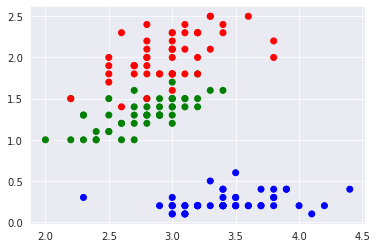

In [18]:
I = Iris_Df
I.Species.unique()
colors = {'Iris-setosa' : 'blue', 'Iris-versicolor' : 'green', 'Iris-virginica' : 'red'}
I['color'] = I.Species.apply(lambda x : colors[x])
plt.scatter(I['SepalWidthCm'], I['PetalWidthCm'], c = I['color'])

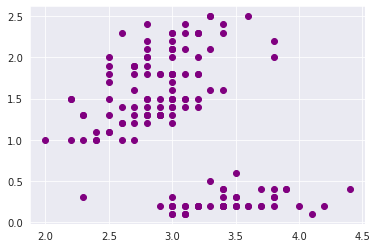

In [4]:
df  = Iris_Df[['SepalWidthCm', 'PetalWidthCm']].copy(deep = True)
plt.scatter(df['SepalWidthCm'], df['PetalWidthCm'], color = 'purple')

In [5]:
mu_df = df.mean(axis = 0, skipna =True)
sigma_df = df.std(axis = 0, skipna =True)

normalization_dictionary = {}

for i in range (df.shape[1]):
  normalization_dictionary[mu_df.index[i]] = {}
  normalization_dictionary[mu_df.index[i]]['mu'] = mu_df[i]
  normalization_dictionary[mu_df.index[i]]['sigma'] = sigma_df[i]

print(normalization_dictionary)

{'SepalWidthCm': {'mu': 3.0540000000000007, 'sigma': 0.4335943113621737}, 'PetalWidthCm': {'mu': 1.1986666666666672, 'sigma': 0.7631607417008414}}


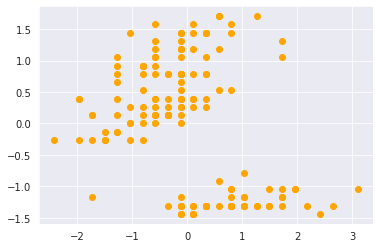

In [6]:
for key in normalization_dictionary.keys():
  df[key]  = (df[key] - normalization_dictionary[key]['mu'])/ normalization_dictionary[key]['sigma']

plt.scatter(df['SepalWidthCm'], df['PetalWidthCm'], color = 'orange')

In [7]:
def to_numpy_array(df):
  X = df.values
  return (X)

In [8]:
 np.random.seed(42)

def initialization(X, number_of_clusters):
  k = number_of_clusters
  
  """phi_j is the Prior Probability"""
  phi_j = np.full(shape = k, fill_value= 1/k)

  """w_ji is the Posterior Probability"""
  w_ji = np.full(shape = (X.shape[0],k), fill_value = 1/k)

  """Take k random numbers in range 0 to the length of the DataFrame"""
  random_row = np.random.randint(low = 0, high = X.shape[0], size=k)

  """ Taking the observation of a random row as mean """
  mu = np.array([X[row_num,:] for row_num in random_row])   

  """Initialize Sigma with the cov matrix of the Dataframe ; stack it k times for k clusters"""

  sigma = np.array([ np.cov(X.T) for _ in range(k) ])
  return (phi_j, w_ji, mu, sigma)

In [9]:
# X = to_numpy_array(df)
# phi_j, w_ji, mu, sigma = initialization(X ,3)
# print(sigma)

In [10]:
from scipy.stats import multivariate_normal

def calculate_W_ji (X, number_of_gaussian, phi_j, mu, sigma):

  """ Dimension of phi_j: K x 1
      Dimension of X is: n x 2
      here, n = 150 """

  k = number_of_gaussian
  likelihood = np.zeros((X.shape[0],k))
  
  """
    Calculate Multivariate Gaussian for all K clusters (1 at a time) for all Data points and 
    save it in likelihood array.

    It calculates P(xi | zi = j ;	θ)
  """
  for i in range (k):
    multivariate_gaussian = multivariate_normal(mean = mu[i], cov = sigma[i])
    likelihood[:,i] = multivariate_gaussian.pdf(X)

  """Calculate the denominator of Bayes Theorem for all i (datapoints) and for all j(clusters)"""

  prior_multiplied_by_likelihood = likelihood * phi_j       # Elementwise Product
  
  ## Dimension of likelihood (n x k)
  ## Hence, Dimension of prior_multiplied_by_likelihood is also (n x k)

  """Calculate the numerator of Bayes Theorem ; Make sure to take sum along every row and then convert 
  it into a 2-D array of shape (n x 1); here n = 150 """

  sum_over_space_of_alternative_hypothesis = np.reshape((prior_multiplied_by_likelihood).sum(axis = 1),(-1,1))
  
  """
                  "prior_multiplied_by_likelihood"    || "sum_over_space_of_alternative_hypothesis"
                                                      ||
                     |cl-0 | cl-1 | cl-2 | cl-3  |    ||          |Sum of Denominator|
                  -------------------------------     ||      ------------------------
                 |D1:| p1  |  p2  | p3   |  p4   |    ||      |D1:|      p_1         |
                  -------------------------------     ||      ------------------------
                 |D2:| p5  |  p6  | p7   |  p8   |    ||      |D2:|      p_2         |
                  -------------------------------     ||      ------------------------
                 |D3:| p9  |  p10 | p11  |  p12  |    ||      |D3:|      p_3         |
                  -------------------------------     ||      ------------------------

                  p_1 = p1 + p2 + p3 + p4
                  p_2 = p5 + p6 + p7 + p8
                  p_3 = p9 + p10 + p11 + p12
  """
  
  W_ji_for_all_j  = prior_multiplied_by_likelihood / sum_over_space_of_alternative_hypothesis

  """Dimension of W_ji_for_all_j is n x k """

  return W_ji_for_all_j

In [11]:
def maximization_step (X, number_of_gaussian, phi_j, W_ji, mu, sigma):
  phi_j = np.mean(W_ji, axis = 0)
  n = number_of_gaussian
  epsilon_identity_matrix = np.eye(2,2) * 0.0000001

  """Calculate mu, sigma for all the Gaussian; Total n Gaussians."""

  for i in range(n):
    
    numerator_for_mu = np.sum(X * np.reshape(W_ji[ :, i],(-1,1)) , axis = 0)
    

    numerator_for_cov = ((np.reshape(W_ji[ :, i],(-1,1)) * (X-mu[i])).T).dot(X-mu[i])

    total_weight = np.sum(W_ji[ :, i])

    mu[i] = numerator_for_mu / total_weight
    sigma[i] = (numerator_for_cov / total_weight) + epsilon_identity_matrix

    # sigma[i] = np.cov((X).T, aweights=(np.reshape(W_ji[ :, i],(-1,1))/total_weight).flatten(), bias=True)

  return phi_j, mu, sigma

In [12]:
def expectation_maximization_assemble(df):
  
  clusters = 3
  max_iteration = 250
  X = to_numpy_array(df)

  """
  If k is the total number of clusters then:
  Initialize the Prior Probability Phi_j = 1/k (Dimension : 1 x k)
  Posterior Probability w_ji = 1/ k (Dimension : n x k)
  mu (Dimension : k x #features) :randomly
  sigma (Dimension : k x #features x #features) :randomly

  """

  phi_j, w_ji, mu, sigma  = initialization(X, clusters)

  for i in range(max_iteration):

    """Expectation (E) Step: Calculate the Posterior Probability P(zi = j | xi)"""
    w_ji = calculate_W_ji (X, clusters, phi_j, mu, sigma)

    """Maximization (M) Step: Update (Improve) the parameters phi_j, mu, sigma"""
    phi_j, mu, sigma = maximization_step (X, clusters, phi_j, w_ji, mu, sigma)

  #Out of For Loop.

  #Final Prediction
  """From the estimated parameters (phi_j, mu, sigma), Calculate the Posterior Probabilty"""
  w_ji = calculate_W_ji (X, clusters, phi_j, mu, sigma)

  """Take the Gaussian which gives the highest probabilty for P(zi =j | xi ; θ)."""
  predicted_class = np.argmax(w_ji, axis =1)

  return predicted_class , phi_j, mu, sigma

In [13]:
# X = to_numpy_array(df)
predicted_class, phi_j, mu, sigma = expectation_maximization_assemble(df)

In [14]:
print(phi_j)

[0.40293406 0.2637354  0.33333054]


In [15]:
print(predicted_class)
unique, counts = np.unique(predicted_class, return_counts=True)
dict(zip(unique, counts))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1
 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


{0: 58, 1: 42, 2: 50}

In [16]:
L = to_numpy_array(df)
a = np.concatenate((L, np.reshape(predicted_class, (-1,1)) ), axis = 1)

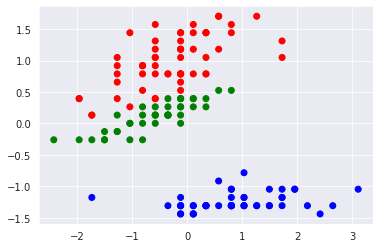

In [17]:
df_predict = pd.DataFrame(a, columns =['SepalWidthCm','PetalWidthCm','c'])
colors = {0: 'red', 1:'green', 2:'blue'}
plt.scatter(df_predict['SepalWidthCm'], df_predict['PetalWidthCm'], 
            c = df_predict['c'].apply(lambda x :colors[x]))